# Lecture 5 Part 1: Real-World Financial Analysis - Tesla (TSLA) Case Study

## Introduction
This notebook is designed to replicate the financial analysis content from Lecture 5 Part 1 using real-world financial data from **Tesla (TSLA)**. We will use the `yfinance` library in Python to fetch the latest market data and calculate key financial ratios.

**Target Audience**: This tutorial is designed for students with **no prior Python experience**. The code blocks include detailed English comments to help you understand the meaning of each step.

**Learning Objectives**:
1.  Learn how to use Python to fetch financial statements of listed companies.
2.  Master the calculation methods for four major categories of financial metrics: **Profitability**, **Liquidity**, **Efficiency**, and **Returns**.
3.  Understand the business logic behind these metrics.

---

## Step 1: Setup

First, we need to import two powerful libraries:
-   `yfinance`: Used to download stock historical data and financial statements from Yahoo Finance.
-   `pandas`: Similar to Excel, used for processing tabular data in Python.

> **Note**: If you haven't installed these packages yet, please uncomment the first line of the code below (remove the `#`) and run it.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
import yfinance as yf

plt.style.use('seaborn-v0_8-whitegrid')


## Step 2: Data Acquisition

We will fetch three major financial statements for Tesla (Ticker: **TSLA**):
1.  **Income Statement**: Reflects how much money the company made.
2.  **Balance Sheet**: Reflects what the company owns (Assets) and what it owes (Liabilities).
3.  **Cash Flow Statement**: Reflects the inflow and outflow of cash (we mainly use the first two in this lesson).

In [2]:
# Preview (statements are loaded and cached in the next cell)


In [3]:
# Step 2: Data Acquisition (Local-first, with yfinance fallback)

DATA_DIR = Path('data')
DATA_DIR.mkdir(parents=True, exist_ok=True)


def load_or_fetch_tesla_statements(ticker: str = 'TSLA', start: str = '2022-01-01'):
    income_path = DATA_DIR / 'tesla_income_stmt.xlsx'
    balance_path = DATA_DIR / 'tesla_balance_sheet.xlsx'
    cash_path = DATA_DIR / 'tesla_cash_flow.xlsx'

    if income_path.exists() and balance_path.exists() and cash_path.exists():
        income = pd.read_excel(income_path, index_col=0)
        balance = pd.read_excel(balance_path, index_col=0)
        cash = pd.read_excel(cash_path, index_col=0)
    else:
        t = yf.Ticker(ticker)
        income = t.financials.transpose()
        balance = t.balance_sheet.transpose()
        cash = t.cashflow.transpose()

        income.to_excel(income_path)
        balance.to_excel(balance_path)
        cash.to_excel(cash_path)

    for df in (income, balance, cash):
        df.index = pd.to_datetime(df.index, errors='coerce')
        df.sort_index(ascending=False, inplace=True)

    start_ts = pd.Timestamp(start)
    income = income[income.index >= start_ts]
    balance = balance[balance.index >= start_ts]
    cash = cash[cash.index >= start_ts]

    return income, balance, cash


income_stmt, balance_sheet, cash_flow = load_or_fetch_tesla_statements()


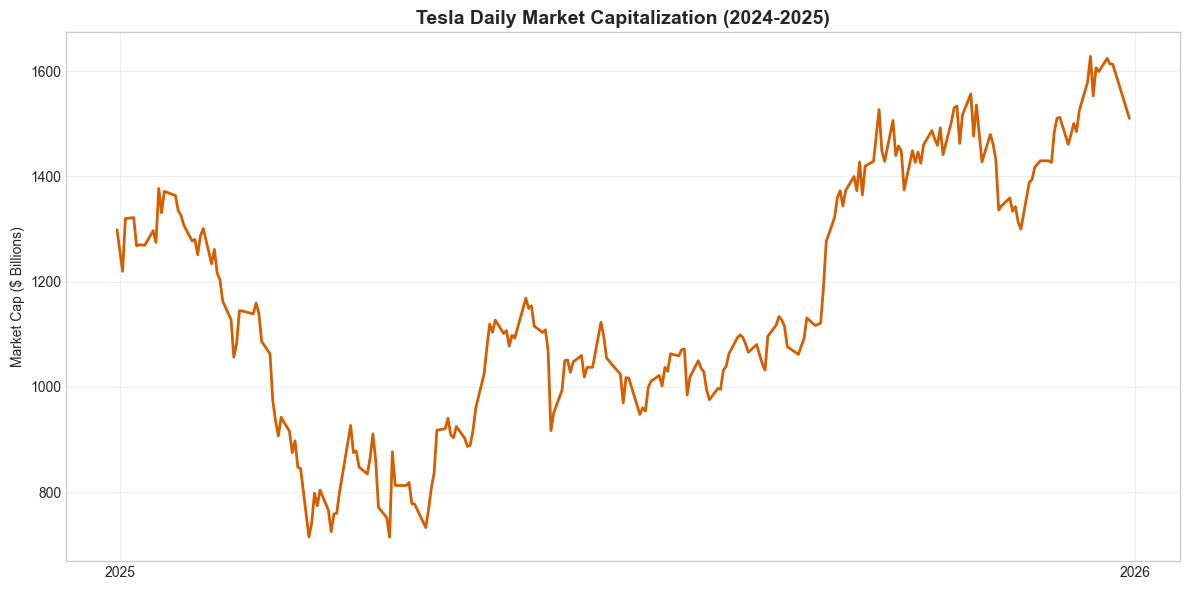

In [4]:
# Market Capitalization Trend (Local-first, with yfinance fallback)

DATA_DIR = Path('data')
DATA_DIR.mkdir(parents=True, exist_ok=True)


def load_or_fetch_excel(path: Path, fetch_fn):
    if path.exists():
        df = pd.read_excel(path, index_col=0)
    else:
        df = fetch_fn()
        df.to_excel(path)
    return df


_t = None

def get_ticker():
    global _t
    if _t is None:
        _t = yf.Ticker('TSLA')
    return _t


daily_path = DATA_DIR / 'tesla_daily_price.xlsx'
q_bs_path = DATA_DIR / 'tesla_quarterly_balance.xlsx'
q_fin_path = DATA_DIR / 'tesla_quarterly_financials.xlsx'


daily_price = load_or_fetch_excel(
    daily_path,
    lambda: get_ticker().history(start='2024-01-01', end='2025-12-31', interval='1d'),
)
daily_price.index = pd.to_datetime(daily_price.index).tz_localize(None)

q_bs = load_or_fetch_excel(q_bs_path, lambda: get_ticker().quarterly_balance_sheet.transpose())
q_bs.index = pd.to_datetime(q_bs.index, errors='coerce')
q_bs = q_bs.sort_index()

q_fin = load_or_fetch_excel(q_fin_path, lambda: get_ticker().quarterly_financials.transpose())
q_fin.index = pd.to_datetime(q_fin.index, errors='coerce')
q_fin = q_fin.sort_index()

shares = None
for col in ['Ordinary Shares Number', 'Share Issued', 'Basic Average Shares']:
    if col in q_bs.columns:
        shares = q_bs[col]
        break
    if col in q_fin.columns:
        shares = q_fin[col]
        break

if shares is None:
    shares = pd.Series(get_ticker().info.get('sharesOutstanding', pd.NA), index=daily_price.index)

shares = shares.dropna().sort_index()
shares_daily = shares.resample('D').ffill().reindex(daily_price.index, method='ffill')

mkt_cap = (daily_price['Close'] * shares_daily) / 1e9

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(mkt_cap.index, mkt_cap, color='#D55E00', linewidth=2)
ax.set_title('Tesla Daily Market Capitalization (2024-2025)', fontsize=14, fontweight='bold')
ax.set_ylabel('Market Cap ($ Billions)')
ax.grid(True, alpha=0.3)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()


## Step 2.1: Understanding Financial Statements with Real Data

We will now break down the core financial concepts and verify them **immediately** using Tesla's real-world data (latest available).

**Note**: We use the `latest_date` variable to ensure checking the most recent report.


### 1. The "Anchor": Balance Sheet
**Core Equation**: $$Assets (A) = Liabilities (L) + Equity (E)$$

*   **Assets**: Where the money went (Investments).
*   **L+E**: Where the money came from (Financing).

Let's verify this equation for Tesla:


In [5]:
# Balance Sheet identity check (Assets = Liabilities + Equity)

latest_date = balance_sheet.index[0]
row = balance_sheet.loc[latest_date]

total_assets = row['Total Assets']
total_liab_nm = row['Total Liabilities Net Minority Interest']
stockholders_equity = row['Stockholders Equity']
minority_interest = row.get('Minority Interest', 0)
minority_interest = 0 if pd.isna(minority_interest) else minority_interest

total_liab_equity = total_liab_nm + stockholders_equity + minority_interest
difference = total_assets - total_liab_equity

print(f"Total Assets:              ${total_assets:,.0f}")
print(f"Total Liab + Equity:       ${total_liab_equity:,.0f}")
print(f"Difference:                ${difference:,.0f}")


Total Assets:              $137,806,000,000
Total Liab + Equity:       $137,806,000,000
Difference:                $0


### 2. The Link: From Income to Equity
**Retained Earnings (RE)** connects the Income Statement and the Balance Sheet.

**Formula**: $$RE_{Ending} = RE_{Beginning} + Net\ Income - Dividends$$

Did Tesla's Retained Earnings grow exactly by its Net Income? Let's trace it.


In [6]:
# Retained earnings bridge: ?RE ? Net Income ? Dividends

re_col = 'Retained Earnings'
if re_col not in balance_sheet.columns:
    re_col = next(
        (
            c
            for c in balance_sheet.columns
            if ('retained' in str(c).lower()) and ('earning' in str(c).lower())
        ),
        re_col,
    )

if re_col in balance_sheet.columns and len(balance_sheet.index) > 1:
    re_ending = balance_sheet.loc[balance_sheet.index[0], re_col]
    re_beginning = balance_sheet.loc[balance_sheet.index[1], re_col]
else:
    re_ending = 0
    re_beginning = 0

net_income = income_stmt.loc[latest_date, 'Net Income']
dividends = 0  # Tesla pays no dividends

actual_change_re = re_ending - re_beginning
theoretical_change = net_income - dividends

print(f"Net Income:                ${net_income:,.0f}")
print(f"Actual Change in RE:       ${actual_change_re:,.0f}")
print(f"Difference:                ${actual_change_re - theoretical_change:,.0f}")


Net Income:                $3,794,000,000
Actual Change in RE:       $3,794,000,000
Difference:                $0


### 3. Free Cash Flow Analysis
**Key Concept**: **Free Cash Flow (FCF)** represents the cash a company generates after accounting for cash outflows to support operations and maintain its capital assets.

$$ \text{Free Cash Flow} = \text{Operating Cash Flow} - \text{Capital Expenditure} $$

FCF is a critical metric because it allows a company to pursue opportunities that enhance shareholder value, such as developing new products, paying dividends, or reducing debt.

In [7]:
# Free Cash Flow (FCF) = Operating Cash Flow + Capital Expenditure

row_cf = cash_flow.loc[latest_date]
operating_cash_flow = row_cf['Operating Cash Flow']
capex = row_cf.get('Capital Expenditure', 0)

free_cash_flow = operating_cash_flow + capex

print(f"Operating Cash Flow:       ${operating_cash_flow:,.0f}")
print(f"+ Capital Expenditure:     ${capex:,.0f}")
print(f"= Free Cash Flow:          ${free_cash_flow:,.0f}")


Operating Cash Flow:       $14,747,000,000
+ Capital Expenditure:     $-8,527,000,000
= Free Cash Flow:          $6,220,000,000


### 4. Liquidity Check
**Final Check**: Does the cash at the bottom of the Cash Flow Statement match the cash on the Balance Sheet?


In [8]:
# Cash reconciliation (Balance Sheet vs Cash Flow)

row_bs = balance_sheet.loc[latest_date]
row_cf = cash_flow.loc[latest_date]

cash_bs = row_bs['Cash And Cash Equivalents']
cash_cf = row_cf['End Cash Position']

diff = cash_bs - cash_cf

print(f"Balance Sheet Cash:        ${cash_bs:,.0f}")
print(f"Cash Flow End Cash:        ${cash_cf:,.0f}")
print(f"Difference:                ${diff:,.0f}")


Balance Sheet Cash:        $16,513,000,000
Cash Flow End Cash:        $17,616,000,000
Difference:                $-1,103,000,000


## [Preview] Market Capitalization Trend (2024-2025)
Below is a preview of the market capitalization trend we will conclude with.


In [9]:
# The market capitalization chart is generated in the previous cell.
